In [124]:
import numpy as np
from biopandas.pdb import PandasPdb
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import scipy
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import directed_hausdorff, cdist
from scipy.optimize import minimize
from itertools import product
from joblib import Parallel, delayed
import multiprocessing
import os

In [91]:
def min_haus(degs, L, D):

    x,y,z,a,b,c = degs

    r = R.from_euler('xyz', [a,b,c])
    D = r.apply(D)

    D = D + [x,y,z]
    haus, _, _ = directed_hausdorff(L, D)

    return haus

def haus_opt(x0, L, D):

    res = minimize(min_haus, x0, method='SLSQP', args=(L,D), options={'ftol': 1e-3, 'disp': False})

    return res['fun'], res['x']

def hcm(L):
    if (len(L) >= 4):
        D = -L
        perm = product(np.linspace(-np.pi, np.pi, 12), repeat=3) #from -pi to pi rads, 24 even groups in between them
        inits_abc = np.array([i for i in perm])
        # iter_xyz = product(np.linspace(-np.max(cdist(c1_xyz, c1_xyz)) /50, np.max(cdist(c1_xyz, c1_xyz)) /50, 3), repeat=3)
        # inits_xyz = np.array([i for i in iter_xyz])
        inits_xyz = np.zeros([1,3])
        inits = np.append(np.tile(inits_xyz, [len(inits_abc), 1]), np.repeat(inits_abc, len(inits_xyz), axis=0), axis=1)

        num_cores = multiprocessing.cpu_count()
        output = Parallel(n_jobs=num_cores)(delayed(haus_opt)(i, L, D) for i in inits)
        values = [_[0] for _ in output]
        return(min(values) / np.max(cdist(L,L)))
    else:
        return 0

In [3]:
def get_radius(A, p, r):
    dists = cdist(A,p.reshape(1,3)).reshape(-1)
    within_cutoff = (dists <= r)
    selection = A[within_cutoff]
    return selection

In [214]:
def osipov_whole(coord):
    n = 2
    m = 1

    N = len(coord)

    if N >= 4:
        P = np.array(list(itertools.permutations(np.arange(N), 4))) # Get permutations

        coords_P = coord[P]
        r = coords_P - np.roll(coords_P, -1, axis=1)
        r[:, 3] = -r[:, 3]
        r_mag = np.linalg.norm(r, axis=-1)
        cross_vecs = np.cross(r[:, 0], r[:, 2])
        G_p_up = np.einsum('ij,ij->i', cross_vecs, r[:, 3]) * np.einsum('ij,ij->i', r[:, 0], r[:, 1]) * np.einsum('ij,ij->i', r[:, 1], r[:, 2])
        G_p_down = np.power(np.prod(r_mag[:,0:3], axis=-1), n) * np.power(r_mag[:, 3], m)

        print(np.sum(G_p_down==0))

        G_p = (1 / 3) * np.sum(G_p_up / G_p_down)

        G_os = (24)/(N ** 4) *  G_p

    else:
        G_os = 0

    return G_os

In [5]:
MW = {'C': 12.01,
      'O': 16.00,
      'N': 14.01,
      'P': 30.97, }

In [105]:
b_pdb_name = '1BNA.pdb'
b_coord = PandasPdb()
b_coord.read_pdb(b_pdb_name)
b_atoms = b_coord.df['ATOM']

In [106]:
BDNA_base_hcm = []
BDNA_base_opd = []
BDNA_base_pairs_hcm = []
BDNA_base_pairs_opd = []
for ii in np.arange(1, 13):
    b_bp1 = b_atoms.query('residue_number == %d' %ii)[['x_coord', 'y_coord', 'z_coord']].to_numpy()
    b_bp2 = b_atoms.query('residue_number == %d' %(25-ii))[['x_coord', 'y_coord', 'z_coord']].to_numpy()

    BDNA_base_hcm.append(hcm(b_bp1))
    BDNA_base_hcm.append(hcm(b_bp2))
    BDNA_base_opd.append(osipov_whole(b_bp1))
    BDNA_base_opd.append(osipov_whole(b_bp2))
    b_bp_paired = np.concat([b_bp1, b_bp2], axis=0)
    BDNA_base_pairs_hcm.append(hcm(b_bp_paired))
    BDNA_base_pairs_opd.append(osipov_whole(b_bp_paired))

In [94]:
b_sug_coords = []
b_phos_coords = []
b_acid_coords = []
b_ntide_coords = []

for ii in b_atoms.residue_number.unique():
    b_sug = b_atoms.query("residue_number == %d & atom_name.str.contains(\"'\", na=False) & atom_name != \"O5'\" & atom_name != \"O3'\"" %ii)
    b_phos = b_atoms.query("residue_number == %d & (atom_name.str.contains(\"P\", na=False) | atom_name == \"O5'\" | atom_name == \"O3'\")" %ii)
    b_acid = b_atoms[~(b_atoms.isin(b_phos) | b_atoms.isin(b_sug))].query("residue_number == %d" %ii)
    b_ntide = b_atoms.query("residue_number == %d" %ii)
    b_ntide_coords.append(np.average(b_ntide[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in b_ntide['element_symbol']]))
    b_sug_coords.append(np.average(b_sug[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in b_sug['element_symbol']]))
    b_phos_coords.append(np.average(b_phos[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in b_phos['element_symbol']]))
    b_acid_coords.append(np.average(b_acid[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in b_acid['element_symbol']]))

b_sug_coords = np.asarray(b_sug_coords)
b_phos_coords = np.asarray(b_phos_coords)
b_acid_coords = np.asarray(b_acid_coords)
b_ntide_coords = np.asarray(b_ntide_coords)
b_atoms_coords = b_atoms[['x_coord', 'y_coord', 'z_coord']].to_numpy()

In [96]:
a_pdb_name = '1D28.pdb'
a_coord = PandasPdb()
a_coord.read_pdb(a_pdb_name)
a_atoms = a_coord.df['ATOM']

In [107]:
ADNA_base_hcm = []
ADNA_base_opd = []
ADNA_base_pairs_hcm = []
ADNA_base_pairs_opd = []
for ii in np.arange(1, 13):
    a_bp1 = a_atoms.query('residue_number == %d' %ii)[['x_coord', 'y_coord', 'z_coord']].to_numpy()
    a_bp2 = a_atoms.query('residue_number == %d' %(25-ii))[['x_coord', 'y_coord', 'z_coord']].to_numpy()

    ADNA_base_hcm.append(hcm(a_bp1))
    ADNA_base_hcm.append(hcm(a_bp2))
    ADNA_base_opd.append(osipov_whole(a_bp1))
    ADNA_base_opd.append(osipov_whole(a_bp2))
    a_bp_paired = np.concat([a_bp1, a_bp2], axis=0)
    ADNA_base_pairs_hcm.append(hcm(a_bp_paired))
    ADNA_base_pairs_opd.append(osipov_whole(a_bp_paired))

In [98]:
a_sug_coords = []
a_phos_coords = []
a_acid_coords = []
a_ntide_coords = []

for ii in a_atoms.residue_number.unique():
    a_sug = a_atoms.query("residue_number == %d & atom_name.str.contains(\"'\", na=False) & atom_name != \"O5'\" & atom_name != \"O3'\"" %ii)
    a_phos = a_atoms.query("residue_number == %d & (atom_name.str.contains(\"P\", na=False) | atom_name == \"O5'\" | atom_name == \"O3'\")" %ii)
    a_acid = a_atoms[~(a_atoms.isin(a_phos) | a_atoms.isin(a_sug))].query("residue_number == %d" %ii)
    a_ntide = a_atoms.query("residue_number == %d" %ii)
    a_ntide_coords.append(np.average(a_ntide[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in a_ntide['element_symbol']]))
    a_sug_coords.append(np.average(a_sug[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in a_sug['element_symbol']]))
    a_phos_coords.append(np.average(a_phos[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in a_phos['element_symbol']]))
    a_acid_coords.append(np.average(a_acid[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in a_acid['element_symbol']]))

a_sug_coords = np.asarray(a_sug_coords)
a_phos_coords = np.asarray(a_phos_coords)
a_acid_coords = np.asarray(a_acid_coords)
a_ntide_coords = np.asarray(a_ntide_coords)
a_atoms_coords = a_atoms[['x_coord', 'y_coord', 'z_coord']].to_numpy()

In [100]:
z_pdb_name = '4OCB.pdb'
z_coord = PandasPdb()
z_coord.read_pdb(z_pdb_name)
z_atoms = z_coord.df['ATOM']
z_atoms = z_atoms.query('alt_loc != "B"')

In [108]:

ZDNA_base_hcm = []
ZDNA_base_opd = []
ZDNA_base_pairs_hcm = []
ZDNA_base_pairs_opd = []
for ii in np.arange(1, 13):
    z_bp1 = z_atoms.query('residue_number == %d & segment_id == "A"' %ii)[['x_coord', 'y_coord', 'z_coord']].to_numpy()
    z_bp2 = z_atoms.query('residue_number == %d & segment_id == "A_2"' %(13-ii))[['x_coord', 'y_coord', 'z_coord']].to_numpy()

    ZDNA_base_hcm.append(hcm(z_bp1))
    ZDNA_base_hcm.append(hcm(z_bp2))
    ZDNA_base_opd.append(osipov_whole(z_bp1))
    ZDNA_base_opd.append(osipov_whole(z_bp2))
    z_bp_paired = np.concat([z_bp1, z_bp2], axis=0)
    ZDNA_base_pairs_hcm.append(hcm(z_bp_paired))
    ZDNA_base_pairs_opd.append(osipov_whole(z_bp_paired))

In [102]:
z_unique_res = z_atoms[['residue_number', 'segment_id']].drop_duplicates(ignore_index=True)

z_sug_coords = []
z_phos_coords = []
z_acid_coords = []
z_ntide_coords = []

for ii in z_unique_res.index:
    # print(ii)
    z_ntide = z_atoms.query('residue_number == %d & segment_id == "%s"' %(z_unique_res.loc[ii, 'residue_number'], z_unique_res.loc[ii, 'segment_id'])).reset_index()
    z_sug = z_ntide.query("atom_name.str.contains(\"'\", na=False) & atom_name != \"O5'\" & atom_name != \"O3'\"")
    z_phos = z_ntide.query("(atom_name.str.contains(\"P\", na=False) | atom_name == \"O5'\" | atom_name == \"O3'\")")
    z_acid = z_ntide[~(z_ntide.isin(z_phos) | z_ntide.isin(z_sug)).any(axis=1)]

    z_ntide_coords.append(np.average(z_ntide[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in z_ntide['element_symbol']]))
    z_sug_coords.append(np.average(z_sug[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in z_sug['element_symbol']]))
    z_phos_coords.append(np.average(z_phos[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in z_phos['element_symbol']]))
    z_acid_coords.append(np.average(z_acid[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in z_acid['element_symbol']]))

z_sug_coords = np.asarray(z_sug_coords)
z_phos_coords = np.asarray(z_phos_coords)
z_acid_coords = np.asarray(z_acid_coords)
z_ntide_coords = np.asarray(z_ntide_coords)
z_atoms_coords = z_atoms[['x_coord', 'y_coord', 'z_coord']].to_numpy()

In [ ]:
bp_hcms = pd.DataFrame(np.array([ADNA_base_pairs_hcm, BDNA_base_pairs_hcm, ZDNA_base_pairs_hcm]).T, columns=['A-DNA hcm', 'B-DNA hcm', 'Z-DNA hcm'])
bp_hcms.to_csv('bp_hcms.csv', index=False)
bp_opds = pd.DataFrame(np.array([ADNA_base_pairs_opd, BDNA_base_pairs_opd, ZDNA_base_pairs_opd]).T, columns=['A-DNA opd', 'B-DNA opd', 'Z-DNA opd'])
bp_opds.to_csv('bp_opds.csv', index=False)

In [18]:
ntide_opd = np.asarray([osipov_whole(a_ntide_coords), osipov_whole(b_ntide_coords), osipov_whole(z_ntide_coords)])
sug_opd = np.asarray([osipov_whole(a_sug_coords), osipov_whole(b_sug_coords), osipov_whole(z_sug_coords)])
phos_opd = np.asarray([osipov_whole(a_phos_coords), osipov_whole(b_phos_coords), osipov_whole(z_phos_coords)])
acid_opd = np.asarray([osipov_whole(a_acid_coords), osipov_whole(b_acid_coords), osipov_whole(z_acid_coords)])

ntide_hcm = np.asarray([hcm(a_ntide_coords), hcm(b_ntide_coords), hcm(z_ntide_coords)])
sug_hcm = np.asarray([hcm(a_sug_coords), hcm(b_sug_coords), hcm(z_sug_coords)])
phos_hcm = np.asarray([hcm(a_phos_coords), hcm(b_phos_coords), hcm(z_phos_coords)])
acid_hcm = np.asarray([hcm(a_acid_coords), hcm(b_acid_coords), hcm(z_acid_coords)])

In [37]:
whole_hcms = pd.DataFrame(np.stack([ntide_hcm, sug_hcm, phos_hcm, acid_hcm]), columns=['A-DNA hcm', 'B-DNA hcm', 'Z-DNA hcm'], index=['ntide', 'sugar', 'phos', 'nacid'])
whole_hcms.to_csv('whole_hcms.csv')

whole_opds = pd.DataFrame(np.stack([ntide_opd, sug_opd, phos_opd, acid_opd]), columns=['A-DNA opd', 'B-DNA opd', 'Z-DNA opd'], index=['ntide', 'sugar', 'phos', 'nacid'])
whole_opds.to_csv('whole_opds.csv')

In [138]:
pdb_files = [_ for _ in os.listdir() if _[-4:] == '.pdb']
pdb_files.sort()

In [240]:
all_ntide_coords = [[] for _ in pdb_files]
for jj in range(len(pdb_files)):
# jj = 0
    pdb_name = pdb_files[jj]
    coord = PandasPdb()
    coord.read_pdb(pdb_name)
    atoms = coord.df['ATOM']

    unique_res = atoms[['residue_number', 'segment_id']].drop_duplicates(ignore_index=True)
    ntide_coords = []
    for ii in unique_res.index:
        ntide = atoms.query('residue_number == %d & segment_id == "%s"' %(unique_res.loc[ii, 'residue_number'], unique_res.loc[ii, 'segment_id'])).reset_index()
        all_ntide_coords[jj].append(np.average(ntide[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in ntide['element_symbol']]))

    all_ntide_coords[jj] = np.array(all_ntide_coords[jj])

In [247]:
chain_hcms = np.asarray([hcm(_) for _ in all_ntide_coords])
chain_opds = np.asarray([osipov_whole(_) for _ in all_ntide_coords])

In [276]:
a_chain_hcms = [chain_hcms[_] for _ in [0,2,4,6]]
a_chain_opds = [chain_opds[_] for _ in [0,2,4,6]]

b_chain_hcms = [chain_hcms[_] for _ in [1,3,5,7,8]]
b_chain_opds = [chain_opds[_] for _ in [1,3,5,7,8]]

z_chain_hcms = [chain_hcms[_] for _ in [9,10,11,12]]
z_chain_opds = [chain_opds[_] for _ in [9,10,11,12]]

In [271]:
z_unique_res = z_atoms[['residue_number', 'segment_id']].drop_duplicates(ignore_index=True)

z_sug_coords = []
z_phos_coords = []
z_acid_coords = []
z_ntide_coords = []

for ii in z_unique_res.index:
    # print(ii)
    z_ntide = z_atoms.query('residue_number == %d & segment_id == "%s"' %(z_unique_res.loc[ii, 'residue_number'], z_unique_res.loc[ii, 'segment_id'])).reset_index()
    z_sug = z_ntide.query("atom_name.str.contains(\"'\", na=False) & atom_name != \"O5'\" & atom_name != \"O3'\"")
    z_phos = z_ntide.query("(atom_name.str.contains(\"P\", na=False) | atom_name == \"O5'\" | atom_name == \"O3'\")")
    z_acid = z_ntide[~(z_ntide.isin(z_phos) | z_ntide.isin(z_sug)).any(axis=1)]

    z_ntide_coords.append(np.average(z_ntide[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in z_ntide['element_symbol']]))
    z_sug_coords.append(np.average(z_sug[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in z_sug['element_symbol']]))
    z_phos_coords.append(np.average(z_phos[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in z_phos['element_symbol']]))
    z_acid_coords.append(np.average(z_acid[['x_coord', 'y_coord', 'z_coord']].to_numpy(), axis=0, weights=[MW[_] for _ in z_acid['element_symbol']]))

z_sug_coords = np.asarray(z_sug_coords)
z_phos_coords = np.asarray(z_phos_coords)
z_acid_coords = np.asarray(z_acid_coords)
z_ntide_coords = np.asarray(z_ntide_coords)
z_atoms_coords = z_atoms[['x_coord', 'y_coord', 'z_coord']].to_numpy()

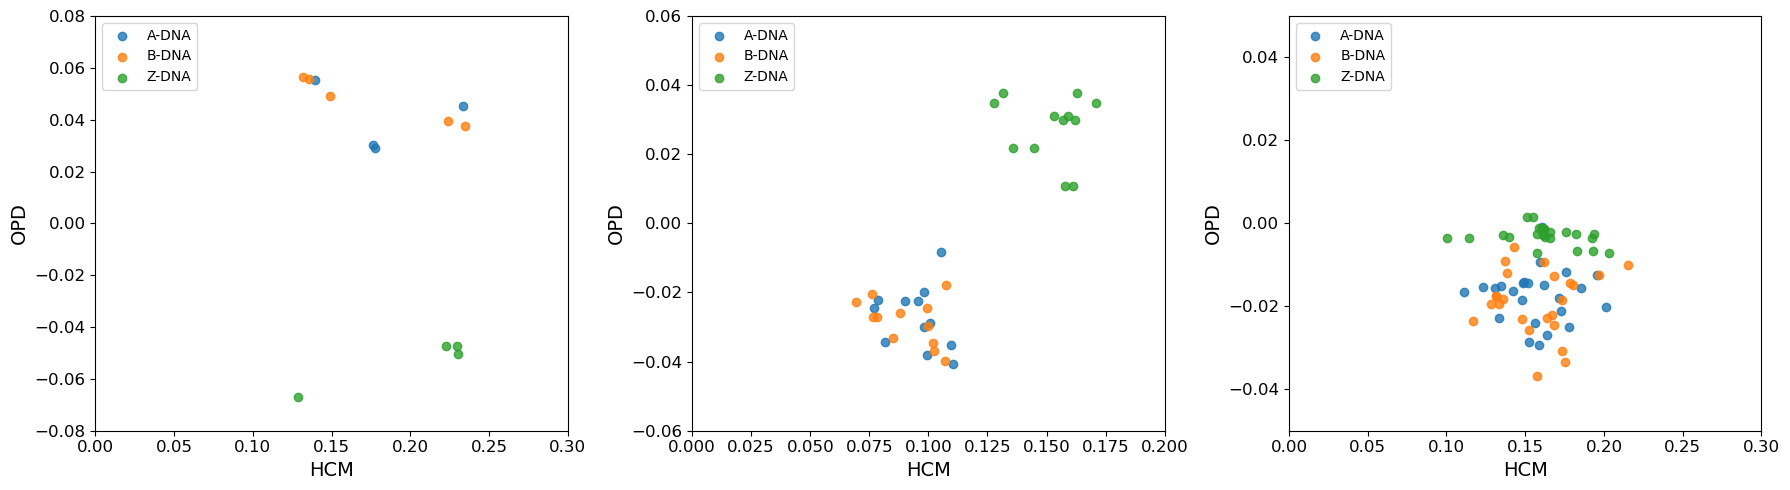

In [279]:
fsize = 14
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1,3,1)

ax1.scatter(a_chain_hcms, a_chain_opds, alpha=0.8)
ax1.scatter(b_chain_hcms, b_chain_opds, alpha=0.8)
ax1.scatter(z_chain_hcms, z_chain_opds, alpha=0.8)

ax1.set_xlim(0, 0.3)
ax1.set_ylim(-0.08, 0.08)
ax1.legend(['A-DNA', 'B-DNA', 'Z-DNA'], loc='upper left')
ax1.set_xlabel('HCM', fontsize=fsize)
ax1.set_ylabel('OPD', fontsize=fsize)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=12)

ax2 = fig.add_subplot(1,3,2)

ax2.scatter(ADNA_base_pairs_hcm, ADNA_base_pairs_opd, alpha=0.8)
ax2.scatter(BDNA_base_pairs_hcm, BDNA_base_pairs_opd, alpha=0.8)
ax2.scatter(ZDNA_base_pairs_hcm, ZDNA_base_pairs_opd, alpha=0.8)

ax2.set_xlim(0, 0.2)
ax2.set_ylim(-0.06, 0.06)
ax2.legend(['A-DNA', 'B-DNA', 'Z-DNA'], loc='upper left')
ax2.set_xlabel('HCM', fontsize=fsize)
ax2.set_ylabel('OPD', fontsize=fsize)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=12)

ax3 = fig.add_subplot(1,3,3)

ax3.scatter(ADNA_base_hcm, ADNA_base_opd, alpha=0.8)
ax3.scatter(BDNA_base_hcm, BDNA_base_opd, alpha=0.8)
ax3.scatter(ZDNA_base_hcm, ZDNA_base_opd, alpha=0.8)

ax3.set_xlim(0, 0.3)
ax3.set_ylim(-0.05, 0.05)
ax3.legend(['A-DNA', 'B-DNA', 'Z-DNA'], loc='upper left')
ax3.set_xlabel('HCM', fontsize=fsize)
ax3.set_ylabel('OPD', fontsize=fsize)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='minor', labelsize=12)

plt.tight_layout()
plt.savefig('dna.png', dpi=600)
plt.show()

In [273]:
a_corr_chains = scipy.stats.pearsonr(a_chain_hcms, a_chain_opds)
b_corr_chains = scipy.stats.pearsonr(b_chain_hcms, b_chain_opds)
z_corr_chains = scipy.stats.pearsonr(z_chain_hcms, z_chain_opds)
a_corr_pairs = scipy.stats.pearsonr(ADNA_base_pairs_hcm, ADNA_base_pairs_opd)
b_corr_pairs = scipy.stats.pearsonr(BDNA_base_pairs_hcm, BDNA_base_pairs_opd)
z_corr_pairs = scipy.stats.pearsonr(ZDNA_base_pairs_hcm, ZDNA_base_pairs_opd)
a_corr_single = scipy.stats.pearsonr(ADNA_base_hcm, ADNA_base_opd)
b_corr_single = scipy.stats.pearsonr(BDNA_base_hcm, BDNA_base_opd)
z_corr_single = scipy.stats.pearsonr(ZDNA_base_hcm, ZDNA_base_opd)

In [274]:
print(a_corr_chains)
print(b_corr_chains)
print(z_corr_chains)
print(a_corr_pairs)
print(b_corr_pairs)
print(z_corr_pairs)
print(a_corr_single)
print(b_corr_single)
print(z_corr_single)

PearsonRResult(statistic=np.float64(-0.1874164994162139), pvalue=np.float64(0.812583500583786))
PearsonRResult(statistic=np.float64(-0.9810169515505546), pvalue=np.float64(0.0031307059808643426))
PearsonRResult(statistic=np.float64(0.9809901695328059), pvalue=np.float64(0.019009830467194178))
PearsonRResult(statistic=np.float64(-0.19766896366013964), pvalue=np.float64(0.53801710299834))
PearsonRResult(statistic=np.float64(-0.40594844633081306), pvalue=np.float64(0.1904116191745878))
PearsonRResult(statistic=np.float64(-0.12715120974871513), pvalue=np.float64(0.693736717224368))
PearsonRResult(statistic=np.float64(-0.031352988431802495), pvalue=np.float64(0.8843687373638058))
PearsonRResult(statistic=np.float64(0.037894107101816364), pvalue=np.float64(0.8604551137022993))
PearsonRResult(statistic=np.float64(-0.29695280751772724), pvalue=np.float64(0.1587979116666235))
